In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils import resample #to downsample the dataset
from sklearn.preprocessing import scale #Scale the dataset
from sklearn.svm import SVC #Support vector machine for classification
from sklearn.metrics import plot_confusion_matrix #Draws a Confusion Matrix

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
def inv_mee(true_target, predicted_target):
    return 1/mee(true_target, predicted_target)

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mee(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mean_squared_error(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']]
X = df_task_tr.drop(labels=['x','y'], axis=1)
X_test = df_blind_ts

print(y.shape)

(1477, 2)


In [ ]:
X_all = X.values
y_all = y.values

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=420)
print(f"X shape: {X_train.shape}")
print(f"X validation shape: {X_validation.shape}")
print(f"y shape: {y_train.shape}")
print(f"y validation shape: {y_validation.shape}")

X shape: (1329, 10)
X validation shape: (148, 10)
y shape: (1329, 2)
y validation shape: (148, 2)


In [ ]:
#from sklearn.preprocessing import scale #Scale the dataset

#X_train_scaled = scale(X_train)
#X_val_scaled = scale(X_validation)
#X_test_scaled = scale (X_test)

In [ ]:
y_train = y_train[['x', 'y']]
y_validation = y_validation[['x', 'y']]

In [ ]:
X_train_C = np.ascontiguousarray(X_train, dtype=np.double) #np.ascontiguousarray(X_train_scaled, dtype=np.double)
X_val_C = np.ascontiguousarray(X_validation, dtype=np.double) #np.ascontiguousarray(X_val_scaled, dtype=np.double)
X_test_C = np.ascontiguousarray(X_test, dtype=np.double) #np.ascontiguousarray(X_test_scaled, dtype=np.double)

In [ ]:
y_train_C = np.ascontiguousarray(y_train.values, dtype=np.double)
y_validation_C = np.ascontiguousarray(y_validation.values, dtype=np.double)

In [ ]:
pipe_svr = Pipeline([('reg', MultiOutputRegressor(SVR()))])
grid_param_svr = {
    'reg__estimator__C':[0.1, 0.5, 0.8, 0.9, 1, 2, 5, 10],
    'reg__estimator__epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
    'reg__estimator__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'reg__estimator__kernel':  ['linear', 'rbf', 'sigmoid']
}

In [ ]:
optimal_par = RandomizedSearchCV(
    estimator=pipe_svr,
    param_distributions=grid_param_svr,
    n_iter=100,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=0
)

optimal_par.fit(X_train, y_train) #optimal_par.fit(X_train_scaled, y_train)
print(optimal_par.best_params_)

{'reg__estimator__kernel': 'rbf', 'reg__estimator__gamma': 'scale', 'reg__estimator__epsilon': 0.5, 'reg__estimator__C': 5}


In [ ]:
best_model = optimal_par.best_estimator_
best_model.fit(X_train, y_train) #best_model.fit(X_train_scaled, y_train)
best_model.score(X_validation, y_validation) #best_model.score(X_val_scaled, y_validation)

0.9596238585512655

In [ ]:
df_results_cup = pd.DataFrame(data=optimal_par.cv_results_) #trasform into a pandas dataframe
df_results_cup

#https://github.com/scikit-learn/scikit-learn/issues/2439 se è negativo controlla questo

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124988,0.006614,0.014785,0.001348,rbf,0.001,0.5,5,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-2.674152,...,-2.419263,-1.902505,-2.426437,-2.549076,-2.589057,-2.254511,-2.266068,-2.400133,0.210647,49
1,0.135997,0.006003,0.016402,0.002792,rbf,0.001,0.5,0.8,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-5.009575,...,-4.574644,-3.634975,-4.879618,-4.892332,-4.703884,-4.332167,-4.210181,-4.525948,0.392743,63
2,0.156745,0.006707,0.018651,0.001002,rbf,0.1,0.1,0.1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-2.086164,...,-1.764610,-1.384807,-1.602322,-1.851975,-1.698011,-1.672192,-1.764629,-1.763514,0.195102,12
3,0.154504,0.013217,0.014912,0.002045,sigmoid,0.00001,1,0.1,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-33.753531,...,-30.480162,-29.067982,-34.053163,-31.945676,-32.893733,-30.273456,-29.451673,-31.357161,1.667698,92
4,0.075254,0.005035,0.005327,0.000072,linear,0.00001,1,0.1,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.560491,...,-2.326736,-1.977557,-2.382271,-2.429899,-2.524101,-2.274122,-2.250033,-2.359993,0.168962,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.048846,0.003397,0.006013,0.000304,sigmoid,0.001,2,5,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-3.451977,...,-3.265870,-2.581550,-3.230370,-3.427254,-3.563258,-3.090157,-3.007336,-3.207854,0.262064,56
96,0.270560,0.013721,0.020301,0.003367,rbf,0.1,0.1,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",-1.298727,...,-1.077793,-0.887951,-0.997445,-1.155837,-1.130830,-1.079915,-1.147730,-1.111202,0.177977,3
97,0.169805,0.012051,0.015177,0.000149,sigmoid,0.00001,0.1,1,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",-33.263745,...,-30.000858,-28.539843,-33.434992,-31.426318,-32.047773,-29.816222,-28.964676,-30.808513,1.622805,86
98,0.074225,0.005386,0.005280,0.000053,linear,0.0001,1,0.1,"{'reg__estimator__kernel': 'linear', 'reg__est...",-2.560491,...,-2.326736,-1.977557,-2.382271,-2.429899,-2.524101,-2.274122,-2.250033,-2.359993,0.168962,17


In [ ]:
C_BEST = optimal_par.best_params_['reg__estimator__C']
GAMMA = optimal_par.best_params_['reg__estimator__gamma']
KERNEL = optimal_par.best_params_['reg__estimator__kernel']
EPSILON = optimal_par.best_params_['reg__estimator__epsilon']

clf_svr_cup = SVR(C=C_BEST, gamma=GAMMA, kernel=KERNEL, epsilon=EPSILON)
mor = MultiOutputRegressor(clf_svr_cup)
mor.fit(X_train_scaled, y_train)

train_pred = mor.predict(X_train_scaled)
val_pred = mor.predict(X_val_scaled)

In [ ]:
mse_one = mean_squared_error(y_train, train_pred)
print(f'MSE for first regressor: {mse_one}')

MSE for first regressor: 0.8658379552448361


In [ ]:
mse_two = mean_squared_error(y_validation, val_pred)
print(f'MSE for first regressor: {mse_two}')

MSE for first regressor: 0.8183990181421179


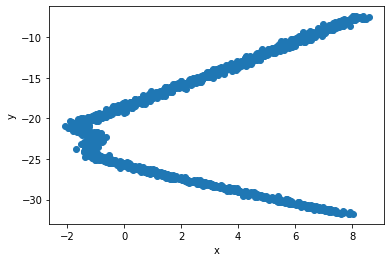

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

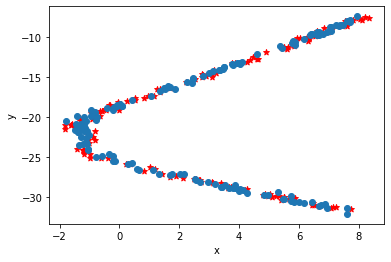

In [ ]:
plot_coordinates(mor, X_val_scaled, y_validation)

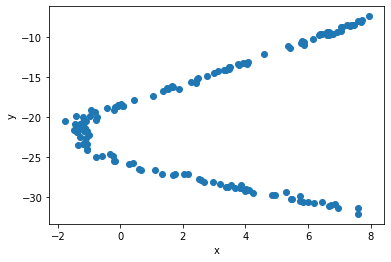

In [ ]:
plot_coordinates(mor, X_val_scaled)

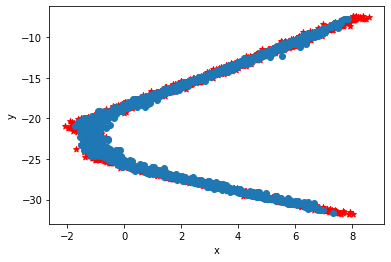

In [ ]:
plot_coordinates(mor, X_all, y_all)

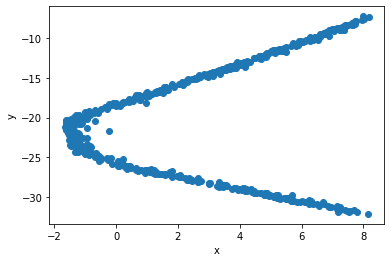

In [ ]:
plot_coordinates(mor, X_test_scaled)

In [ ]:
print(f"Accuracy: {mor.score(X_val_scaled, y_validation)}")
print(f"MEE: {mee(y_validation.values, val_pred)}")

Accuracy: 0.9596238585512655
MEE: 1.0374849414438883


### MEE scoring
Now, we made a RandomizedSearchCV with mee scoring.

In [ ]:
optimal_par_mee = RandomizedSearchCV(
    estimator=pipe_svr,
    param_distributions=grid_param_svr,
    n_iter=100,
    cv=10,
    scoring=make_scorer(inv_mee),
    verbose=0
)

optimal_par_mee.fit(X_train_scaled, y_train.values)
print(optimal_par_mee.best_params_)

{'reg__estimator__kernel': 'rbf', 'reg__estimator__gamma': 'scale', 'reg__estimator__epsilon': 0.5, 'reg__estimator__C': 5}


In [ ]:
best_model = optimal_par_mee.best_estimator_
best_model.fit(X_train_scaled, y_train)
best_model.score(X_val_scaled, y_validation)

0.9596238585512655

In [ ]:
df_results_cup = pd.DataFrame(data=optimal_par_mee.cv_results_) #trasform into a pandas dataframe
df_results_cup

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.173438,0.011536,0.015793,0.002340,sigmoid,0.0001,0.01,0.8,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.141882,...,0.150360,0.152776,0.140593,0.146674,0.144177,0.150155,0.152436,0.147896,0.004165,76
1,0.169924,0.006199,0.015054,0.000858,sigmoid,0.01,0,1,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.489930,...,0.509969,0.581178,0.505251,0.503306,0.493963,0.515988,0.528373,0.512998,0.025773,51
2,0.069017,0.003876,0.009231,0.001743,rbf,0.1,1,0.1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.580299,...,0.637623,0.696836,0.633855,0.598900,0.622047,0.604941,0.603563,0.617951,0.034923,13
3,0.092015,0.006210,0.012981,0.001762,rbf,0.00001,2,0.9,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.133204,...,0.141407,0.143417,0.132174,0.137917,0.135202,0.141129,0.143642,0.139019,0.003984,82
4,0.167464,0.005225,0.007567,0.000972,linear,0.01,0.1,0.9,"{'reg__estimator__kernel': 'linear', 'reg__est...",0.499187,...,0.526387,0.573504,0.520492,0.517495,0.508338,0.525344,0.525227,0.521395,0.020589,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.133168,0.010501,0.016014,0.000421,rbf,0.00001,0.01,0.1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.131162,...,0.139116,0.141210,0.130288,0.135916,0.133619,0.138873,0.141461,0.136932,0.003826,87
96,0.358945,0.016066,0.008042,0.000821,linear,0.00001,0.01,5,"{'reg__estimator__kernel': 'linear', 'reg__est...",0.499799,...,0.524495,0.572181,0.519317,0.517524,0.509647,0.524475,0.527123,0.521082,0.020235,50
97,0.150878,0.004859,0.018160,0.002358,rbf,1,0,0.1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.178763,...,0.194951,0.197375,0.175847,0.183786,0.183333,0.196396,0.193357,0.188496,0.007218,69
98,0.129302,0.004151,0.016065,0.000799,rbf,0.0001,0.01,1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.161542,...,0.170995,0.174351,0.159591,0.166352,0.163698,0.170803,0.172408,0.168039,0.004804,72


In [ ]:
df_results = pd.DataFrame(data=optimal_par_mee.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=True, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:100] #keep only top 50 models
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__kernel,param_reg__estimator__gamma,param_reg__estimator__epsilon,param_reg__estimator__C,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
16,0.140597,0.012546,0.012312,0.001967,rbf,scale,0.5,5,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.825747,...,0.914628,0.978807,0.924313,0.822022,0.869922,0.843727,0.821232,0.872254,0.073542,1
59,0.287930,0.012262,0.018511,0.000544,rbf,0.1,0.01,10,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.817932,...,0.914010,0.957377,0.885134,0.812191,0.867584,0.843023,0.813341,0.860990,0.066213,2
23,0.175933,0.007123,0.017104,0.000470,rbf,0.1,0.1,1,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.778384,...,0.871533,0.950115,0.874954,0.814779,0.847719,0.814478,0.792807,0.840963,0.064585,3
13,0.078213,0.007916,0.006749,0.000235,rbf,0.1,1,2,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.759105,...,0.876382,0.948402,0.877703,0.786288,0.822059,0.812211,0.800270,0.834020,0.073410,4
35,0.020968,0.001517,0.002966,0.000417,rbf,0.1,2,2,"{'reg__estimator__kernel': 'rbf', 'reg__estima...",0.645647,...,0.737293,0.760644,0.731910,0.657416,0.680544,0.682974,0.680097,0.693880,0.043939,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.220465,0.012271,0.020592,0.001759,sigmoid,scale,0,5,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.017796,...,0.018075,0.018932,0.019096,0.018586,0.017368,0.018217,0.017310,0.017942,0.000730,96
54,0.227959,0.006438,0.021951,0.002614,sigmoid,1,0.01,0.9,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.012196,...,0.008953,0.008596,0.009837,0.009097,0.009026,0.008708,0.008408,0.009338,0.001034,97
63,0.228100,0.008706,0.020757,0.001560,sigmoid,1,2,0.9,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.012163,...,0.008956,0.008618,0.009858,0.009097,0.009027,0.008707,0.008416,0.009337,0.001024,98
43,0.225554,0.005702,0.020828,0.002596,sigmoid,0.1,1,10,"{'reg__estimator__kernel': 'sigmoid', 'reg__es...",0.009024,...,0.009014,0.009445,0.009679,0.009370,0.008780,0.009067,0.008640,0.009004,0.000383,99


In [ ]:
C_BEST = optimal_par.best_params_['reg__estimator__C']
GAMMA = optimal_par.best_params_['reg__estimator__gamma']
KERNEL = optimal_par.best_params_['reg__estimator__kernel']
EPSILON = optimal_par.best_params_['reg__estimator__epsilon']

clf_svr_cup = SVR(C=C_BEST, gamma=GAMMA, kernel=KERNEL, epsilon=EPSILON)
mor_mee = MultiOutputRegressor(clf_svr_cup)
mor_mee.fit(X_train_scaled, y_train)

train_pred = mor_mee.predict(X_train_scaled)
val_pred = mor_mee.predict(X_val_scaled)

In [ ]:
print(f"Accuracy: {mor_mee.score(X_train_scaled, y_train.values)}")
print(f"MEE: {mee(y_train.values, train_pred)}")

Accuracy: 0.9515748153986898
MEE: 1.007594899803706


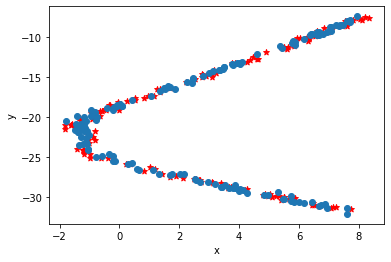

In [ ]:
plot_coordinates(mor_mee, X_val_scaled, y_validation)

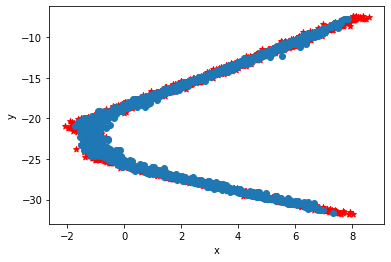

In [ ]:
plot_coordinates(mor_mee, X_all, y_all)

In [ ]:
print(f"Accuracy: {mor_mee.score(X_val_scaled, y_validation)}")
print(f"MEE: {mee(y_validation.values, val_pred)}")

Accuracy: 0.9596238585512655
MEE: 1.0374849414438883


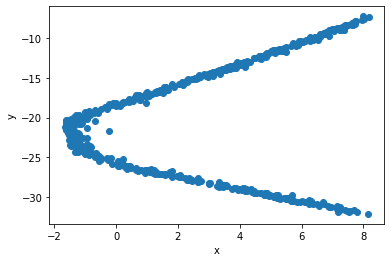

In [ ]:
plot_coordinates(mor_mee, X_test_scaled)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>